In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob, Word
from sklearn.metrics import accuracy_score, roc_auc_score , confusion_matrix ,classification_report


## Data Preprocessing 

In [75]:
df_= pd.read_csv("IMDB Dataset.csv")
df = df_.copy

In [76]:

na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
missing_df = pd.DataFrame(missing_df)
    

print("--------------------- Shape --------------------")
print(df.shape)
print("-------------------- Types ---------------------")
print(df.dtypes)
print("--------------------- Head ---------------------")
print(df.head())
        

AttributeError: 'function' object has no attribute 'columns'

TypeError: 'method' object is not subscriptable

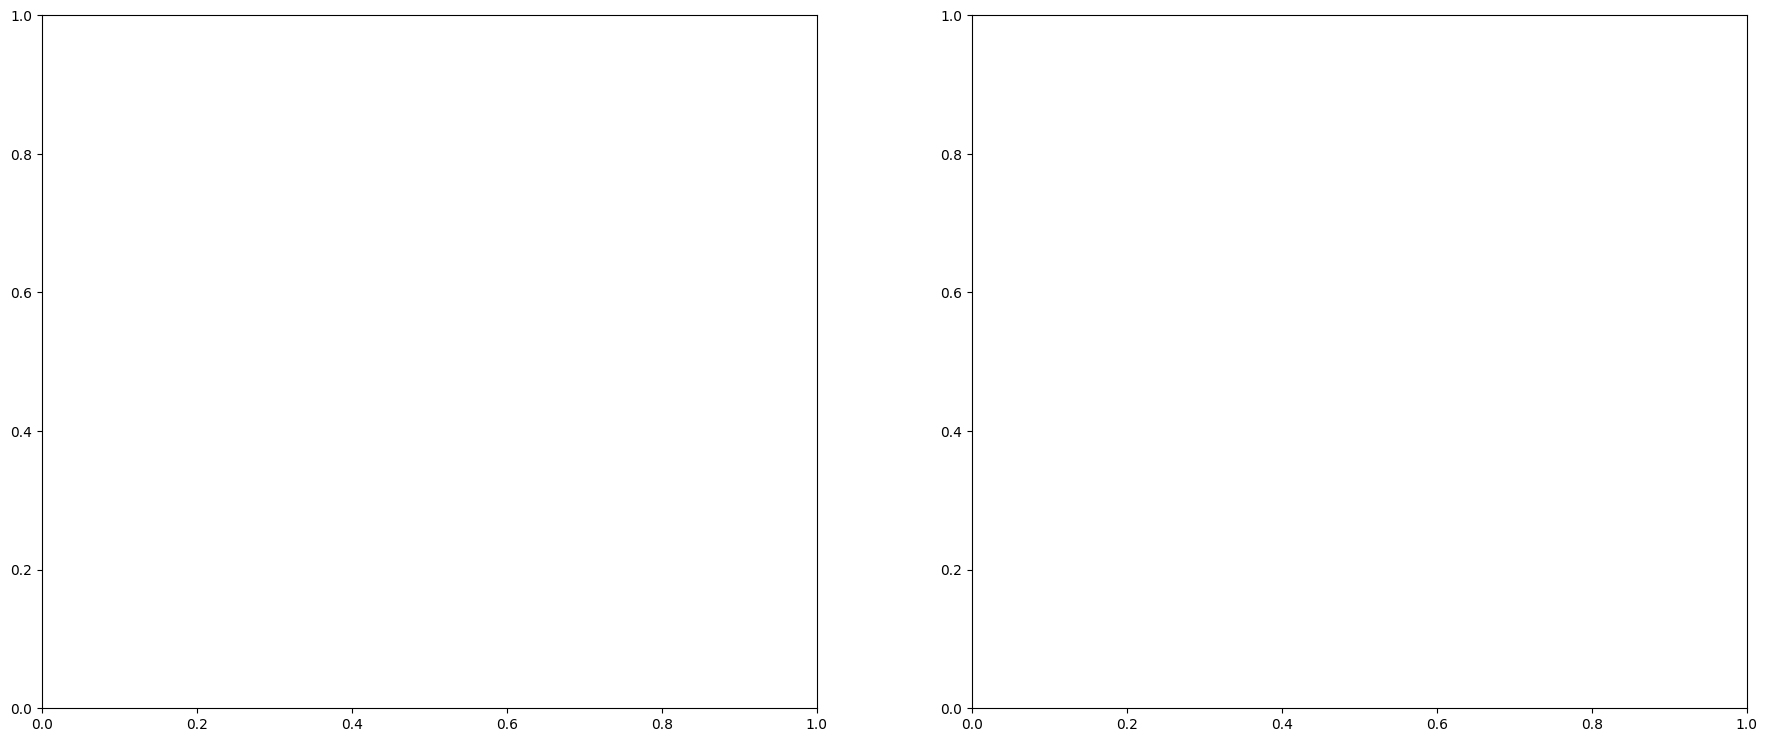

In [68]:
a , ax = plt.subplots(1,2,figsize=(22,9))
df['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300, colors = ["#bcbddc", "#efedf5"])
ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')
sns.countplot('sentiment', data = df ,ax=ax[1], palette=["#bcbddc", "#efedf5"])
ax[1].set_title('Distribution of Positive / Negative Emotions')
plt.show()

# Dealing with the single review 

In [38]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [39]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [40]:
df.sentiment.value_counts() 

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [41]:
#train, test splitting of data
x_train , y_train = df.review[:40000], df.sentiment[:40000]
x_test, y_test = df.review[40000:], df.sentiment[40000:]

x_train.shape, y_train.shape , x_test.shape, y_test.shape

((40000,), (40000,), (10000,), (10000,))

In [42]:
data = df.copy()

In [43]:
#remove htmlstrips
def remove_html_strips(text):
    if pd.isnull(text):
        return ""
    if isinstance(text , str):
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
    else:
        text = ""
    return text 

# removing brackets 
def remove_brackets(text):
    if not isinstance(text, str):
        text = str(text)
    pattern = re.compile(r'\[[^]]*\]')
    return pattern.sub(" ", text)
def denoise_text(text):
    text = remove_brackets(text)
    text = remove_html_strips(text)
    return text 

data["review"] = data["review"].apply(denoise_text)

/var/folders/64/n7vytt8d7js7256hfmyywll80000gn/T/ipykernel_53860/1930759494.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [44]:
# removing special characters
def remove_special_char(text):
    if pd.isnull(text):
        return ''
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    return cleaned_text
data['review'] = data['review'].apply(remove_special_char)

Text Stemming 

In [45]:
def stemmer(text):
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split() ])
    return text


In [46]:
# batch processing
# we can try parellel stemming 
# snowball stemmer is faster than poststemmer  
data['review'] = data.apply(lambda row: stemmer(row['review']), axis=1)

In [51]:
stopword_list = nltk.corpus.stopwords.words("english")
stop=set(stopwords.words('english'))
print(stop)
tokenizer = ToktokTokenizer()


#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

{'yourselves', 'this', 'before', 'y', 's', 'hers', "mightn't", 'itself', 'any', 'too', 'about', 'she', 'off', 'under', 'below', 'ourselves', 'can', 'only', 'hasn', 'further', 'her', 'how', 'on', 'who', 'whom', 'will', 'then', 'all', "you'll", 'your', 'its', 'don', 'these', 'yours', 'was', 'for', "isn't", 'didn', 'out', 'with', 'up', 'nor', 'mightn', 'couldn', 'that', 'the', 'why', 'o', "don't", 'should', 'am', 'from', 'll', 'yourself', 'own', "shouldn't", "it's", 'once', 'in', 'each', 'mustn', "shan't", 'their', "couldn't", "haven't", 'weren', "you'd", 'you', 'what', 'it', 'being', 'an', 'of', 'through', 'are', 'no', 'those', 'doesn', 'wasn', 'he', 're', 'm', 'd', 'both', 'doing', 'wouldn', "you've", 'having', 'because', 'until', "hasn't", 'some', 'again', 'ma', "that'll", "hadn't", "didn't", 'theirs', 'ain', 'they', 'been', 'more', 'were', 'there', 'few', 'or', 'where', 'has', 'we', 'had', 'a', 'herself', 'against', 'during', 'between', 'very', 'down', 'above', 'does', 'aren', 'our', 

In [52]:
data['review'] = data['review'].apply(remove_stopwords)

In [56]:
norm_train_reviews = data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp